In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features)
from cities.utils.cleaning_utils import check_if_tensed 

from pyro.infer import Predictive

In [2]:
def plot_predictive(model, data, intervention_variable, outcome_dataset, forward_shift, guide = None, **kwargs):

    model = condition(data=dict(**kwargs))(model)
    
    #if guide:
    #    guide_tr = pyro.poutine.trace(guide).get_trace()
    #    model_tr = pyro.poutine.trace(pyro.poutine.replay(model(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
    #                            time_index = time_index, intervention = intervention), trace=guide_tr)).get_trace()
    #else:
    with pyro.poutine.trace() as tr:
        model(**kwargs)

    model_tr = tr.trace
    y = model_tr.nodes['y']['value']

    predictive_copy = data.copy()

    predictive_copy['post_test'] = y.reshape(-1, 1).detach().numpy()  

    sns.pairplot(predictive_copy[[intervention_variable, f"{outcome_dataset}_shifted_by_{forward_shift}", 'post_test']])
    

In [3]:
dg = DataGrabber()


outcome_dataset = 'unemployment_rate'
intervention_dataset = 'spending_commerce'
intervention_variable = 'total_obligated_amount'
forward_shift = 2

tensed_covariates_datasets = [var for var in list_tensed_features() if var not in [outcome_dataset, intervention_dataset]]
fixed_covariates_datasets = [var for var in list_available_features() if var not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]]

dg.get_features_std_long(list_available_features()) 
dg.get_features_std_wide(list_available_features()) 

year_min = max(dg.std_long[intervention_dataset]['Year'].min(), dg.std_long[outcome_dataset]['Year'].min())
year_max = min(dg.std_long[intervention_dataset]['Year'].max(), dg.std_long[outcome_dataset]['Year'].max())

outcome_df = dg.std_long[outcome_dataset].sort_values(by=['GeoFIPS', 'Year'])

outcome_df[f'{outcome_dataset}_shifted_by_{forward_shift}'] = None

geo_subsets = []
for geo_fips in outcome_df['GeoFIPS'].unique():
    geo_subset = outcome_df[outcome_df['GeoFIPS'] == geo_fips].copy()
    # Shift the 'Value' column `forward_shift` in a new column
    geo_subset[f'{outcome_dataset}_shifted_by_{forward_shift}'] = geo_subset['Value'].shift(-forward_shift)
    geo_subsets.append(geo_subset)
    
outcome_df = pd.concat(geo_subsets).reset_index(drop=True)

outcome = outcome_df[(outcome_df['Year'] >= year_min) & (outcome_df['Year'] <= year_max + forward_shift)]
intervention = dg.std_long[intervention_dataset][(dg.std_long[intervention_dataset]['Year'] >= year_min) & (dg.std_long[intervention_dataset]['Year'] <= year_max)]    
f_covariates = {dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets}
f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
for dataset in f_covariates.keys():
    if dataset != fixed_covariates_datasets[0]:
        if 'GeoName' in f_covariates[dataset].columns:
            f_covariates[dataset] = f_covariates[dataset].drop(columns=['GeoName'])
        f_covariates_joint = f_covariates_joint.merge(f_covariates[dataset], on=['GeoFIPS'])

T_outcome = year_max - year_min + 1

i_o_data = pd.merge(outcome, intervention, on=['GeoFIPS', 'Year'])

if 'GeoName_x' in i_o_data.columns:
    i_o_data.rename(columns={'GeoName_x': "GeoName"}, inplace=True)    
    columns_to_drop = i_o_data.filter(regex=r'^GeoName_[a-zA-Z]$')
    i_o_data.drop(columns=columns_to_drop.columns, inplace=True)

i_o_data.rename(columns={'Value': outcome_dataset}, inplace=True)

i_o_data['state'] = [code // 1000 for code in i_o_data['GeoFIPS']]

N_states = len(i_o_data['state'].unique())

i_o_data.dropna(inplace=True)

i_o_data['unit_index']= pd.factorize(i_o_data['GeoFIPS'].values)[0]
i_o_data['state_index']= pd.factorize(i_o_data['state'].values)[0]
i_o_data['time_index']= pd.factorize(i_o_data['Year'].values)[0]


assert i_o_data['GeoFIPS'].isin(f_covariates_joint['GeoFIPS']).all()

print(i_o_data.shape)
f_covariates_joint.drop(columns=['GeoName'], inplace=True)
data = i_o_data.merge(f_covariates_joint, on='GeoFIPS', how='left')

assert not data.isna().any().any()

(9124, 10)


In [4]:
# getting tensors for modeling
y = data[f'{outcome_dataset}_shifted_by_{forward_shift}']
y = torch.tensor(y, dtype=torch.float32) 
unit_index = torch.tensor(data['unit_index'], dtype=torch.int)
state_index = torch.tensor(data['state_index'], dtype=torch.int)
time_index = torch.tensor(data['time_index'], dtype=torch.int)
intervention = torch.tensor(data[intervention_variable], dtype=torch.float32)
time_index_idx = data.columns.get_loc('time_index')
covariates_df = data.iloc[:, time_index_idx + 1:].copy()
covariates = torch.tensor(covariates_df.values, dtype = torch.float32)

N_cov = covariates.shape[1]

In [5]:
# one way to think about this
import scipy
correlation, _ = scipy.stats.pearsonr(intervention, y)
print(correlation)

# another one
# suppose we care about minimal intervention vs. well-funded places
minimal = data[data['total_obligated_amount'] < -.9]
well = data[(data['total_obligated_amount'] >= .9)]

naive_empirical_estimate = np.mean(well['unemployment_rate_shifted_by_2']) - np.mean(minimal['unemployment_rate_shifted_by_2'])

print(naive_empirical_estimate)

-0.022496748879319295
-0.39838727829041526


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


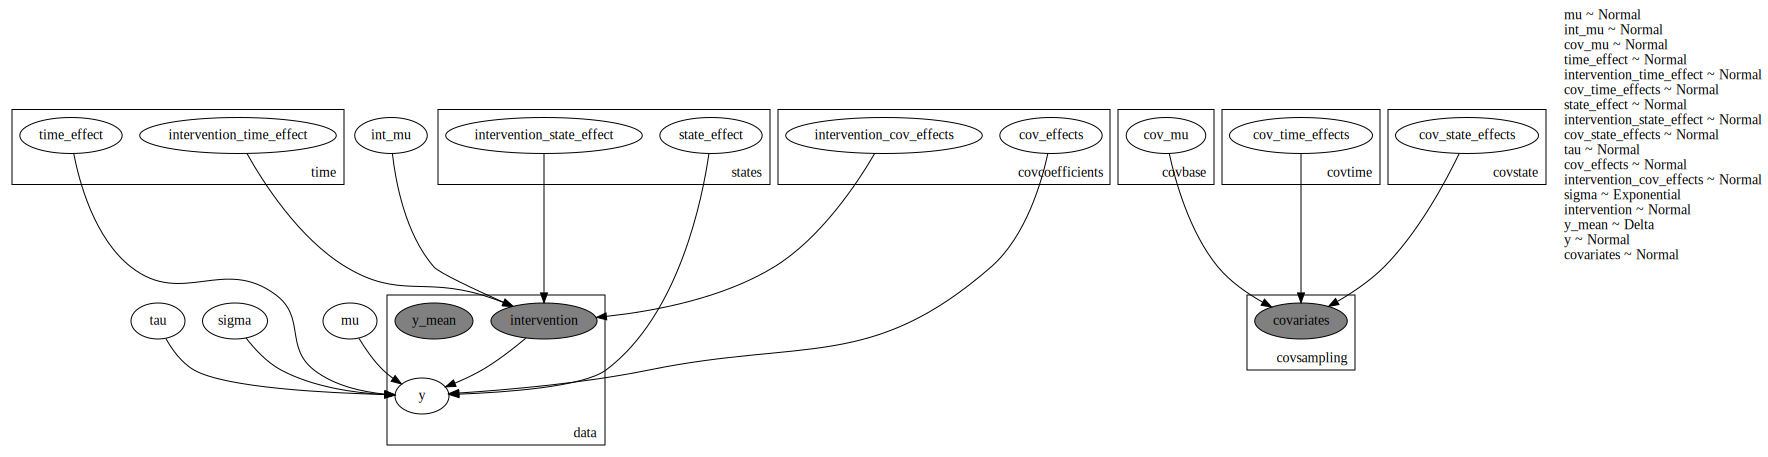

In [6]:
# like model C, but now also covariates are a function
# of time effects and state effects

def cities_model_D(T_outcome, N_states, state_index, time_index,
                    intervention, covariates,
                y = None):
        
        # Intercepts
        mu = pyro.sample("mu", dist.Normal(0, .4))
        intervention_mu = pyro.sample("int_mu", dist.Normal(0, .4))


        with pyro.plate("covbase", N_cov):
                cov_mu = pyro.sample("cov_mu", dist.Normal(0, .4))
 

        # time effect
        with pyro.plate("time", T_outcome):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .5))
                intervention_time_effect = pyro.sample("intervention_time_effect", dist.Normal(0, .5))
        
        with pyro.plate("covtime",  T_outcome * N_cov):
                cov_time_effects = pyro.sample("cov_time_effects",
                                                       dist.Normal(0, 0.5)).reshape(T_outcome, N_cov)


        # state latent confounders
        with pyro.plate("states", N_states):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .5))
                intervention_state_effect = pyro.sample("intervention_state_effect", dist.Normal(0, .5))

        with pyro.plate("covstate", N_states * N_cov):
                cov_state_effects = pyro.sample("cov_state_effects",
                                                        dist.Normal(0, 0.5)).reshape(N_states, N_cov)

        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .5))

        # covariate coefficients
        with pyro.plate("covcoefficients", N_cov):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .5))
                intervention_cov_effects = pyro.sample("intervention_cov_effects", dist.Normal(0, .5))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):

                intervention_mean = (intervention_mu + intervention_time_effect[time_index]
                                      + intervention_state_effect[state_index] +
                                        torch.matmul(covariates, intervention_cov_effects)
                )
                intervention = pyro.sample("intervention", dist.Normal(intervention_mean, 0.5), obs = intervention)

                covariates_means = cov_mu + cov_time_effects[time_index] + cov_state_effects[state_index]

                y_mean = pyro.deterministic("y_mean", mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        with pyro.plate("covsampling", len(time_index) * N_cov):
                covariates = pyro.sample("covariates",
                        dist.Normal(covariates_means.flatten(), 0.5), 
                        obs = covariates.flatten()).reshape(len(time_index), 
                                                            N_cov)

        return  {"y_mean": y_mean, "tau": tau}

cities_model_D(T_outcome, N_states, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_D, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention, covariates), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


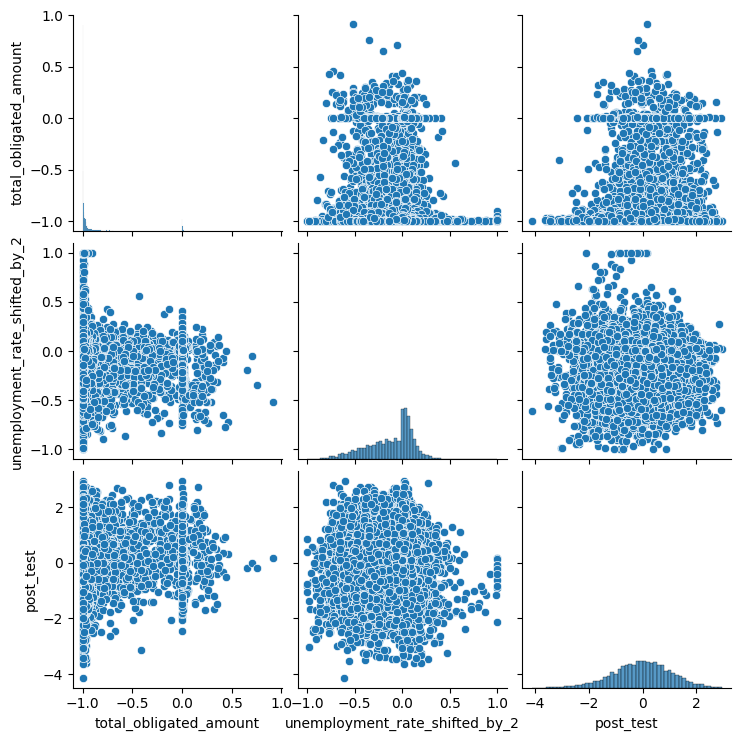

In [7]:
plot_predictive(cities_model_D, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, T_outcome=T_outcome,
  N_states=N_states, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)

[iteration 0001] loss: 24.0992
[iteration 0101] loss: 13.1969
[iteration 0201] loss: 12.4142
[iteration 0301] loss: 12.6332
[iteration 0401] loss: 12.0660
[iteration 0501] loss: 12.0100
[iteration 0601] loss: 12.0392
[iteration 0701] loss: 12.2499
[iteration 0801] loss: 11.8822
[iteration 0901] loss: 11.8518


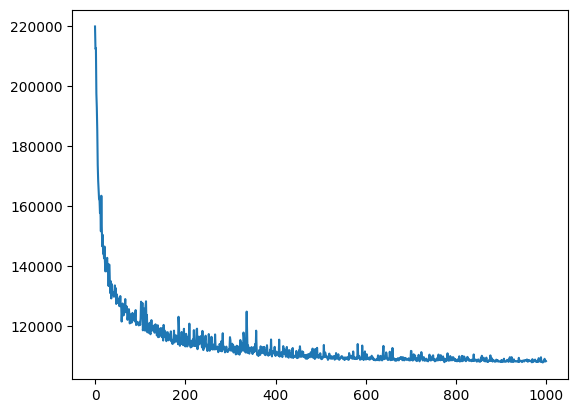

In [8]:
pyro.clear_param_store()
guide_D =  AutoNormal(cities_model_D)


svi = SVI(
    model=cities_model_D,
    guide=guide_D,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))

plt.plot(range(num_iterations),losses, label="Loss")
plt.show()

In [9]:
# parallel=True throws Runtime error, why?
predictive_D = pyro.infer.Predictive(cities_model_D, guide=guide_D, num_samples=1000, parallel=False)
samples_D = predictive_D(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

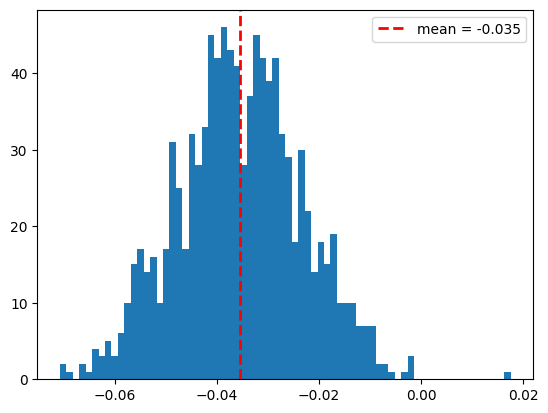

In [10]:
# estimate with covariates and latent confounders impacting covariates, intervention, and outcome
tau_samples = samples_D['tau'].detach().numpy()
plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()

In [11]:
# awfully hacky and awfully slow, but neither changing num_samples nor using plate works

num_countefactual_samples = 50

predictive_D_single = pyro.infer.Predictive(cities_model_D, guide=guide_D, 
                                            num_samples=1, return_sites=("tau", "y_mean", "y"))
with MultiWorldCounterfactual() as mwc:
    with do(actions=dict(intervention=(-0.9, .9))):
            samples_D_counterfactual = []
            for _ in range(num_countefactual_samples):
                 samples_D_counterfactual.append(predictive_D_single(T_outcome = T_outcome, N_states = N_states, 
                                                        state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates))

y_means = []
ys = []
for i in range (num_countefactual_samples):
    # note gather within mwc doesn't work very nice as indices across samples have different names 
    y_means.append(samples_D_counterfactual[i]['y_mean'])
    ys.append(samples_D_counterfactual[i]['y'])
                


In [12]:

y_means_low = []
y_means_high = []
ys_low = []
ys_high = []

for i in range (num_countefactual_samples):
    y_means_low.append(y_means[i].squeeze()[1].tolist())
    y_means_high.append(y_means[i].squeeze()[2].tolist())
    ys_low.append(ys[i].squeeze()[1].tolist())
    ys_high.append(ys[i].squeeze()[2].tolist())

y_means_low_df = pd.DataFrame(y_means_low).T
y_means_high_df = pd.DataFrame(y_means_high).T
ys_low_df = pd.DataFrame(ys_low).T
ys_high_df = pd.DataFrame(ys_high).T

# now the estimated average treatment effect between .9 and -.9 is around 8 times lower
display(y_means_high_df.values.mean() - y_means_low_df.values.mean())

-0.062169819527609804

In [13]:
# summarizing the samples to be able to answer questions 
# about particular locations
def add_samples_summaries(sample_df):
    sample_df['mean'] = sample_df.mean(axis=1)
    sample_df['low'] = sample_df.quantile(0.025, axis=1)
    sample_df['high'] = sample_df.quantile(0.975, axis=1)

dfs_to_summarize = [y_means_low_df, y_means_high_df, ys_low_df, ys_high_df]
for d in dfs_to_summarize:
    add_samples_summaries(d)

display(ys_high_df.head())

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,mean,low,high
0,-0.269704,-0.232483,-0.123563,-0.034229,-0.324738,-0.109936,-0.266490,-0.457045,-0.061604,-0.378089,...,0.006475,-0.171967,-0.178713,-0.294537,-0.203439,-0.127952,-0.147002,-0.235371,-0.568414,0.024970
1,-0.286245,-0.024330,-0.169052,-0.395406,-0.468205,-0.479024,-0.358318,-0.352350,-0.436149,-0.216000,...,-0.211503,-0.394651,0.231605,-0.284495,-0.389413,-0.282311,-0.161078,-0.277246,-0.605896,0.038896
2,-0.208257,-0.064969,-0.394927,-0.395763,-0.134347,-0.279659,-0.443565,-0.651504,-0.285150,-0.641193,...,-0.392096,-0.171819,-0.611096,-0.418379,-0.125481,-0.602713,-0.423897,-0.336745,-0.633669,0.009215
3,-0.595291,-0.069383,-0.213283,-0.152761,-0.658593,-0.055333,-0.347993,-0.493337,-0.127562,-0.411148,...,-0.054866,-0.610590,-0.404598,-0.137675,-0.446286,-0.196542,-0.325872,-0.318856,-0.650826,-0.046176
4,-0.173317,-0.295035,-0.264250,-0.130592,-0.500963,0.038615,-0.102514,-0.570594,-0.323571,-0.436309,...,-0.475307,-0.159097,0.091555,-0.525221,-0.449621,-0.140855,-0.292255,-0.286883,-0.651662,0.023980


(9124, 40)


,GeoFIPS,GeoName,Year,unemployment_rate,unemployment_rate_shifted_by_2,total_obligated_amount,state,unit_index,state_index,time_index,...,prof_sci_mgmt_admin,education_health,arts_entertainment,other_services,public_admin,POPDEN_RUR,POPDEN_URB,HOUDEN_COU,HOUDEN_RUR,ALAND_PCT_RUR
1,1003,"Baldwin County, AL",2011,0.014563,-0.098361,-0.977676,1,1,0,1,...,0.091135,-0.187184,0.065649,0.000626,-0.078084,0.051168,-0.112431,-0.311396,0.09319,-0.026626
2,1003,"Baldwin County, AL",2013,-0.098361,0.000000,-0.996731,1,1,0,2,...,0.091135,-0.187184,0.065649,0.000626,-0.078084,0.051168,-0.112431,-0.311396,0.09319,-0.026626
3,1003,"Baldwin County, AL",2014,-0.020000,0.005291,-0.998153,1,1,0,3,...,0.091135,-0.187184,0.065649,0.000626,-0.078084,0.051168,-0.112431,-0.311396,0.09319,-0.026626
4,1003,"Baldwin County, AL",2015,0.000000,-0.100000,-0.998153,1,1,0,4,...,0.091135,-0.187184,0.065649,0.000626,-0.078084,0.051168,-0.112431,-0.311396,0.09319,-0.026626
5,1003,"Baldwin County, AL",2016,0.005291,-0.172414,-0.985169,1,1,0,5,...,0.091135,-0.187184,0.065649,0.000626,-0.078084,0.051168,-0.112431,-0.311396,0.09319,-0.026626
6,1003,"Baldwin County, AL",2018,-0.172414,-0.117647,-0.972154,1,1,0,6,...,0.091135,-0.187184,0.065649,0.000626,-0.078084,0.051168,-0.112431,-0.311396,0.09319,-0.026626
7,1003,"Baldwin County, AL",2019,-0.322581,-0.459459,-0.999124,1,1,0,7,...,0.091135,-0.187184,0.065649,0.000626,-0.078084,0.051168,-0.112431,-0.311396,0.09319,-0.026626


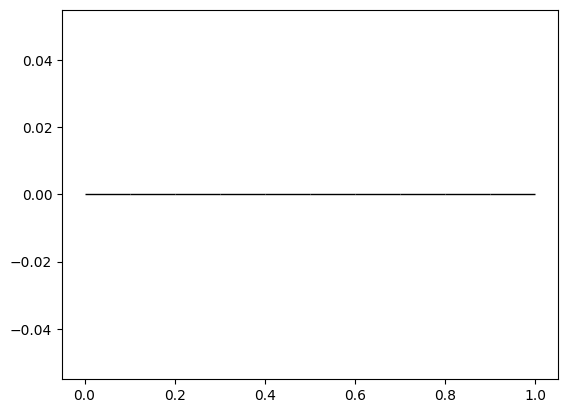

In [28]:
# now suppose I care only about a particular location
print(data.shape)

fips = 1003
year = 2016


display(data[data['GeoFIPS'] == fips])


row_number = data.index[(data['GeoFIPS'] == fips) & (data['Year'] == year)]

unit_samples_row = ys_low_df.iloc[row_number].values.tolist()

plt.hist(unit_samples_row[:-3], bins=10, edgecolor='k')
plt.show()




### Latent confounders have impact on intervention

/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


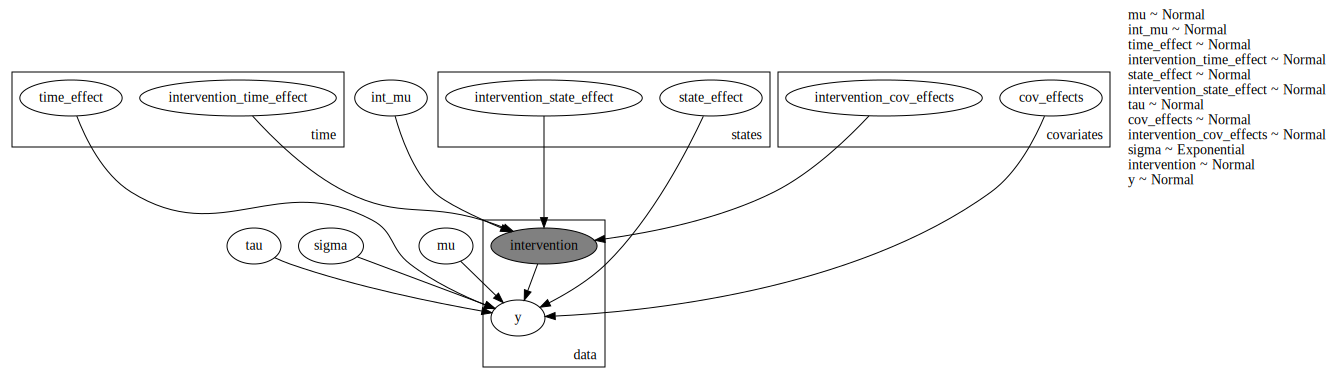

In [5]:
# like model B, but now treatment is a function
# of time effects, state effects, and covariates


def cities_model_C(T_outcome, N_states, state_index, time_index,
                    intervention, covariates,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, .9))
        intervention_mu = pyro.sample("int_mu", dist.Normal(0, .9))

        # time effects
        with pyro.plate("time", T_outcome):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .9))
                intervention_time_effect = pyro.sample("intervention_time_effect", dist.Normal(0, .9))
               
        # state latent confounders
        with pyro.plate("states", N_states):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .9))
                intervention_state_effect = pyro.sample("intervention_state_effect", dist.Normal(0, .9))

        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .9))

        # covariate coefficients
        with pyro.plate("covariates", covariates.shape[1]):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .8))
                intervention_cov_effects = pyro.sample("intervention_cov_effects", dist.Normal(0, .8))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                # print(unit_index)
                
                intervention_mean = (intervention_mu + intervention_time_effect[time_index]
                                      + intervention_state_effect[state_index] +
                                        torch.matmul(covariates, intervention_cov_effects)
                )
                intervention = pyro.sample("intervention", dist.Normal(intervention_mean, 0.9), obs = intervention)


                y_mean = (mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha

cities_model_C(T_outcome, N_states, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_C, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention, covariates), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


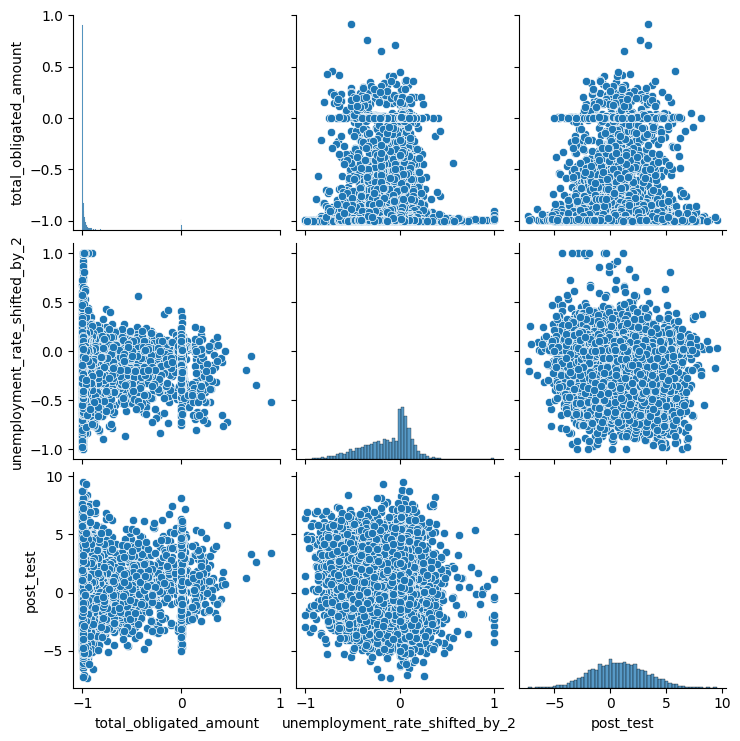

In [6]:
plot_predictive(cities_model_C, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, T_outcome=T_outcome,
  N_states=N_states, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)

In [7]:
pyro.clear_param_store()
guide_C =  AutoNormal(cities_model_C)

# fast but much less informative
#AutoDelta(cities_model_A)

# this is painfully slow
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_C,
    guide=guide_C,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))


[iteration 0001] loss: 2.1006
[iteration 0101] loss: 1.2035
[iteration 0201] loss: 1.1685
[iteration 0301] loss: 0.7481
[iteration 0401] loss: 0.7114
[iteration 0501] loss: 0.7159
[iteration 0601] loss: 0.6827
[iteration 0701] loss: 0.7104
[iteration 0801] loss: 0.5678
[iteration 0901] loss: 0.5843


In [8]:
predictive_C = pyro.infer.Predictive(cities_model_C, guide=guide_C, num_samples=1000, parallel=False)
samples_C = predictive_C(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

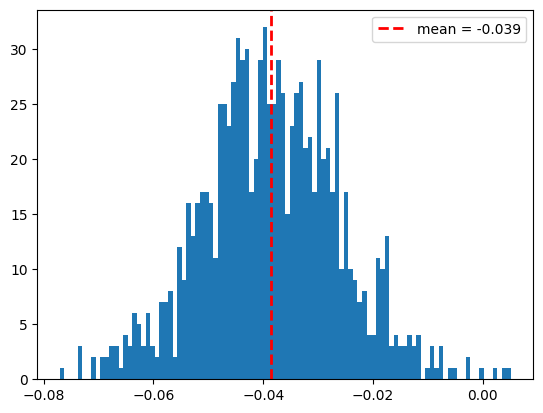

In [9]:
# estimate with covariates and latent confounders impacting intervention

tau_samples = samples_C['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()

### Including covariates


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


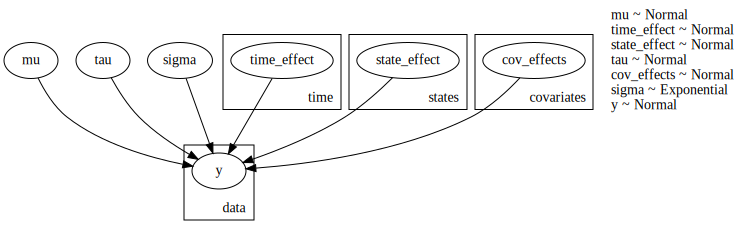

In [5]:
# like vanilla, but with covariates
# and we narrow down the priors as the posterior checked
# revealed too wide posterior


def cities_model_B(T_outcome, N_states, state_index, time_index,
                    intervention, covariates,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, .9))

        # time effects
        with pyro.plate("time", T_outcome):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .9))

        # state latent confounders
        with pyro.plate("states", N_states):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .9))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .9))

        # covariate coefficients
        with pyro.plate("covariates", covariates.shape[1]):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .8))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                # print(unit_index)
                

                y_mean = (mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha

cities_model_B(T_outcome, N_states, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_B, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention, covariates), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


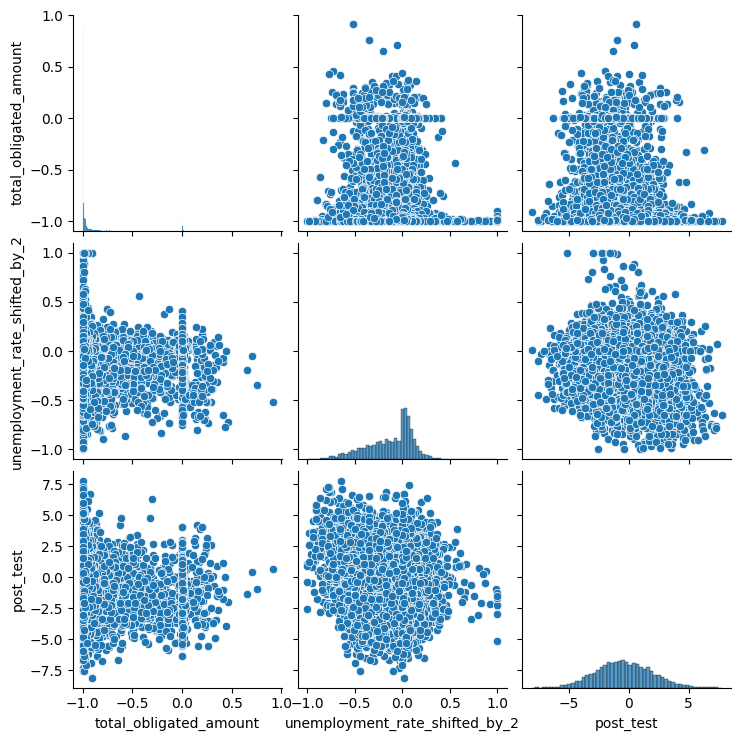

In [6]:
plot_predictive(cities_model_B, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, T_outcome=T_outcome,
  N_states=N_states, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)


In [7]:
pyro.clear_param_store()
guide_B =  AutoNormal(cities_model_B)

# fast but much less informative
#AutoDelta(cities_model_A)

# this is painfully slow
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_B,
    guide=guide_B,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))


[iteration 0001] loss: 0.9400
[iteration 0101] loss: 0.1906
[iteration 0201] loss: -0.0072
[iteration 0301] loss: 0.1215
[iteration 0401] loss: -0.2284
[iteration 0501] loss: -0.0629
[iteration 0601] loss: -0.2875
[iteration 0701] loss: -0.2933
[iteration 0801] loss: -0.3007
[iteration 0901] loss: -0.2932


In [8]:
predictive_B = pyro.infer.Predictive(cities_model_B, guide=guide_B, num_samples=1000, parallel=False)
samples_B = predictive_B(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

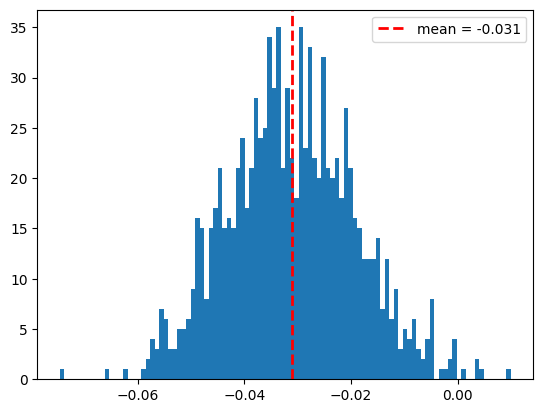

In [9]:
# this is a slightly less naive estimate

tau_samples = samples_B['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()

## Vanilla model

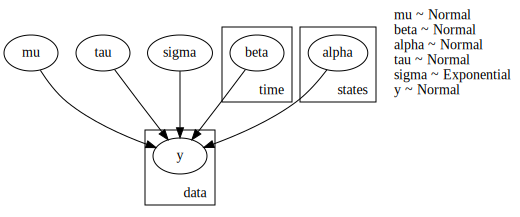

In [42]:
def cities_model_A(T_outcome, N_states, state_index, time_index, intervention,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, 1))

        # time effects
        with pyro.plate("time", T_outcome):
                beta = pyro.sample("beta", dist.Normal(0, 1))

        # state latent confounders
        with pyro.plate("states", N_states):
                alpha = pyro.sample("alpha", dist.Normal(0, 1))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, 1))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                y_mean = mu  + beta[time_index]  + alpha[state_index] + tau * intervention
                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha

pyro.render_model(cities_model_A, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

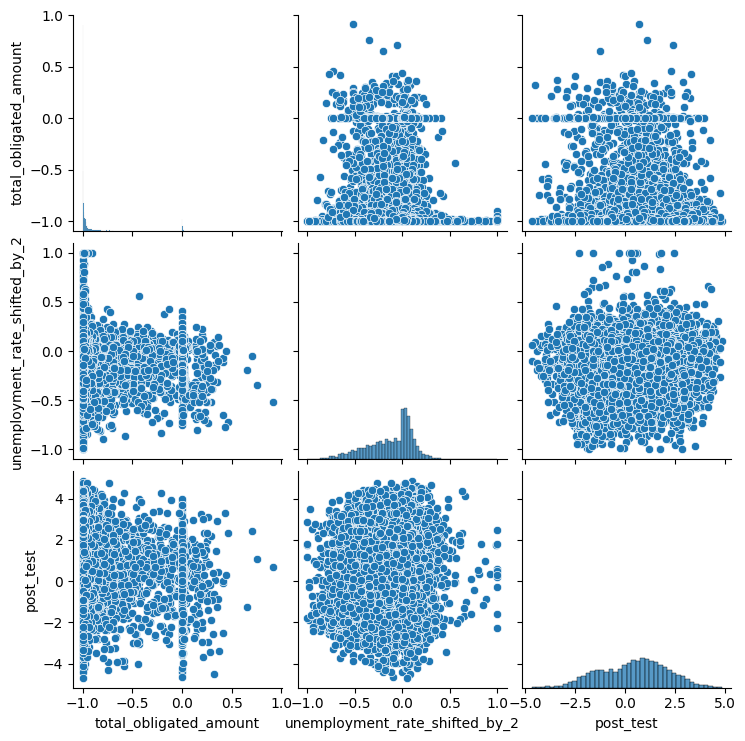

In [44]:
plot_predictive(cities_model_A, T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

In [45]:
pyro.clear_param_store()
guide =  AutoNormal(cities_model_A)

# fast but much less informative
#AutoDelta(cities_model_A)

# this is painfully slow
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_A,
    guide=guide,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))


[iteration 0001] loss: 0.8767
[iteration 0101] loss: 0.3041
[iteration 0201] loss: -0.0483
[iteration 0301] loss: -0.1652
[iteration 0401] loss: -0.1752
[iteration 0501] loss: -0.1711
[iteration 0601] loss: -0.1812
[iteration 0701] loss: -0.1814
[iteration 0801] loss: -0.1814
[iteration 0901] loss: -0.1801


In [46]:
predictive = pyro.infer.Predictive(cities_model_A, guide=guide, num_samples=1000, parallel=False)
samples = predictive(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

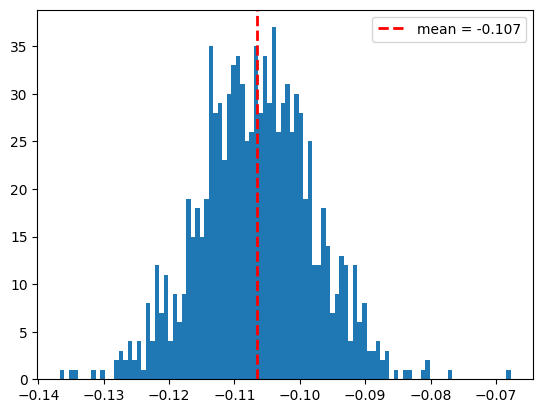

In [47]:
# this is a naive estimate

tau_samples = samples['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()